Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import os
%matplotlib inline 

from os import chdir
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

Introduction

Data Import

In [2]:
# change the path to where you have downloaded the data set

#path = r"C:\Users\RAJI_\Documents\CS\Year 3\Data Mining (Maths)\Assignment2"
path = os.getcwd()

chdir(path)
data = pd.read_csv('CreditCard_train.csv', header =1)

Data Transformation and Exploration

In [3]:
# checking we have the correct data columns and glancing over the data
data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,24000.00000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.00000,24000.000000,24000.000000,24000.000000,24000.000000
mean,12000.500000,165495.986667,1.628250,1.847417,1.55725,35.380458,-0.003125,-0.12350,-0.154750,-0.211667,...,42368.188417,40000.682542,38563.710625,5542.912917,5.815336e+03,4969.26600,4743.480042,4783.486042,5189.399042,0.223750
std,6928.347566,129128.744855,0.483282,0.780007,0.52208,9.271050,1.123425,1.20058,1.204033,1.166549,...,63070.680934,60345.012766,59155.759799,15068.576072,2.079703e+04,16095.61434,14883.269990,15270.405279,17630.371990,0.416765
min,1.000000,10000.000000,1.000000,0.000000,0.00000,21.000000,-2.000000,-2.00000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,6000.750000,50000.000000,1.000000,1.000000,1.00000,28.000000,-1.000000,-1.00000,-1.000000,-1.000000,...,2340.000000,1740.000000,1234.750000,1000.000000,8.000000e+02,379.00000,279.750000,244.000000,60.750000,0.000000
50%,12000.500000,140000.000000,2.000000,2.000000,2.00000,34.000000,0.000000,0.00000,0.000000,0.000000,...,18940.500000,18107.500000,17036.000000,2100.000000,2.000000e+03,1702.50000,1500.000000,1500.000000,1500.000000,0.000000
75%,18000.250000,240000.000000,2.000000,2.000000,2.00000,41.000000,0.000000,0.00000,0.000000,0.000000,...,52188.500000,49746.500000,48796.250000,5000.000000,5.000000e+03,4347.25000,4000.000000,4005.000000,4000.000000,0.000000
max,24000.000000,1000000.000000,2.000000,6.000000,3.00000,79.000000,8.000000,8.00000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,505000.000000,1.684259e+06,896040.00000,497000.000000,417990.000000,528666.000000,1.000000


['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


/Users/hjd970707/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


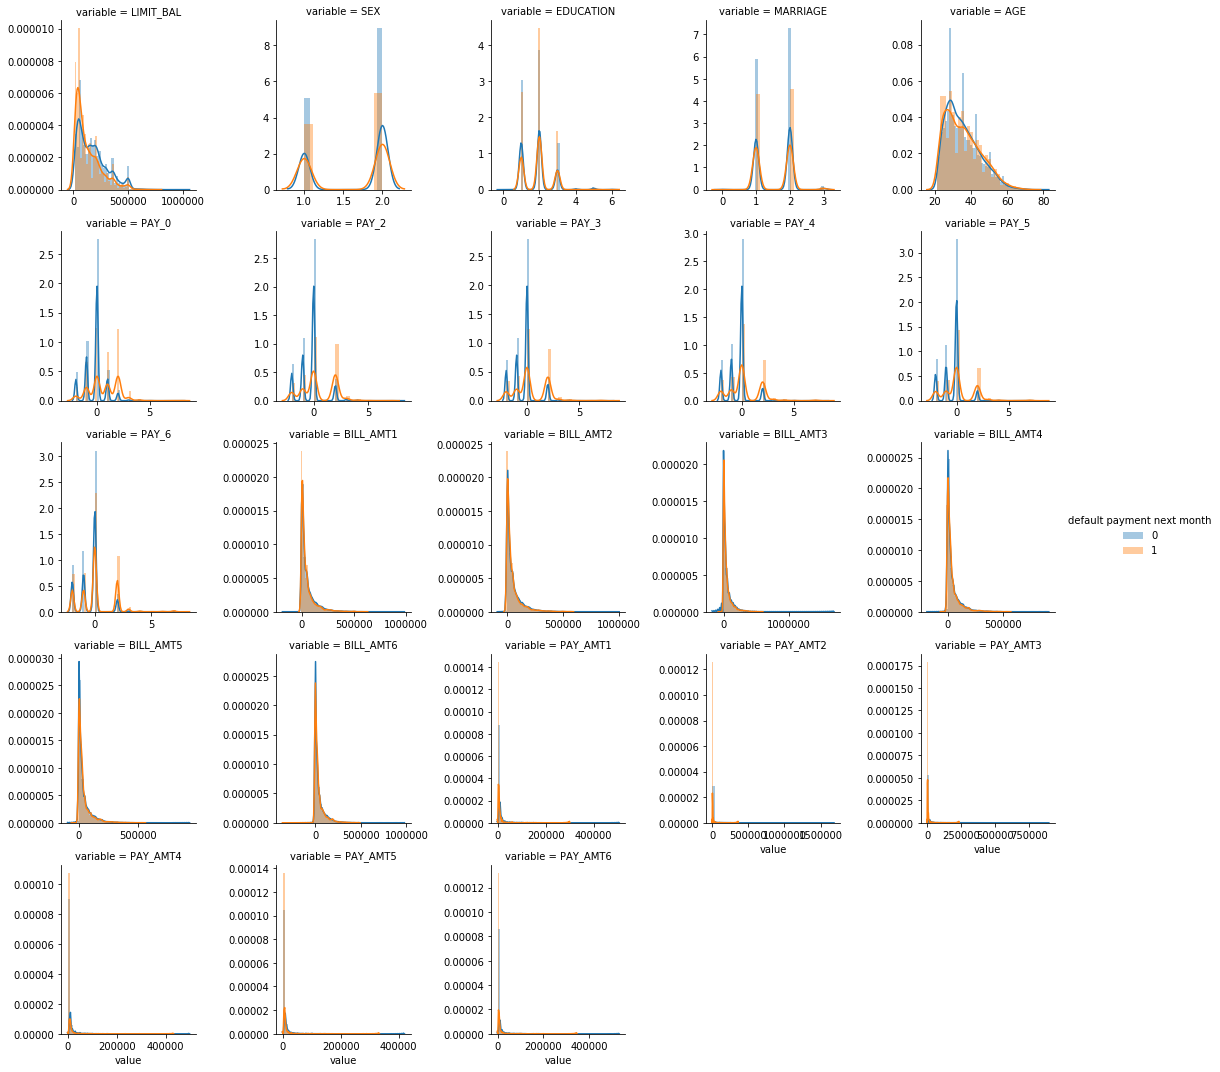

In [4]:
# Let's do a little data visualisation
cols = [ f for f in data.columns if data.dtypes[ f ] != "object" and f!= 'ID']
del cols[-1]
print(cols)

# We plot some distibution plot
f = pd.melt(data, id_vars='default payment next month', value_vars= cols)
g = sns.FacetGrid( f, hue='default payment next month', col="variable", col_wrap=5, sharex=False, sharey=False)
g = g.map( sns.distplot, "value", kde=True).add_legend()

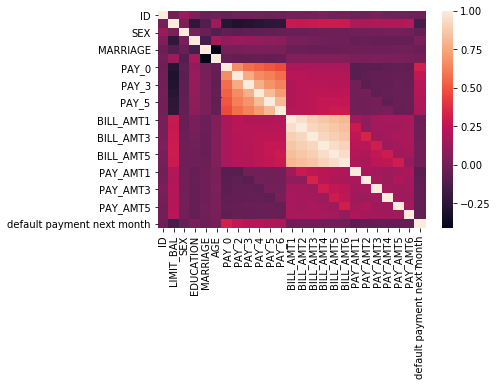

In [5]:
corr = data.corr()

from seaborn import heatmap
heatmap(corr)

plt.show()

/Users/hjd970707/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


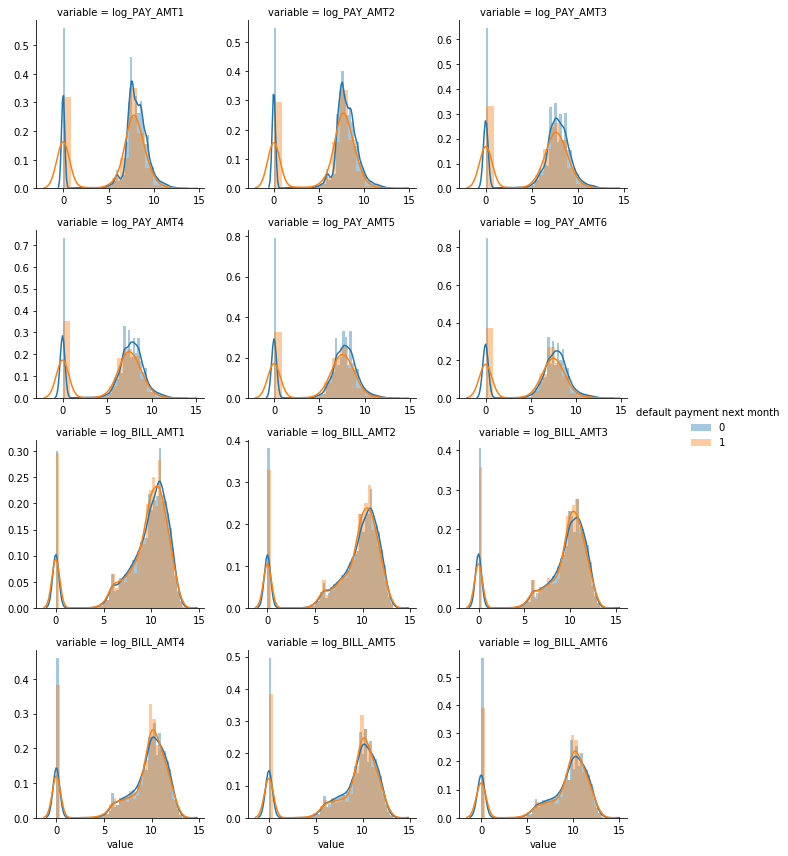

In [6]:
qual_Enc = cols
qual_Enc.remove("LIMIT_BAL")
qual_Enc.remove("AGE")

logged = []
for ii in range(1,7):
    qual_Enc.remove("PAY_AMT" + str( ii ))
    data[ "log_PAY_AMT" + str( ii )]  = data["PAY_AMT"  + str( ii )].apply( lambda x: np.log1p(x) if (x>0) else 0 )
    logged.append("log_PAY_AMT" + str( ii ) )

for ii in range(1,7):
    qual_Enc.remove("BILL_AMT" + str( ii ))
    data[ "log_BILL_AMT" + str( ii )] = data["BILL_AMT" + str( ii )].apply( lambda x: np.log1p(x) if (x>0) else 0 )
    logged.append("log_BILL_AMT" + str( ii ) )

f = pd.melt( data, id_vars='default payment next month', value_vars=logged)
g = sns.FacetGrid( f, hue='default payment next month', col="variable", col_wrap=3, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

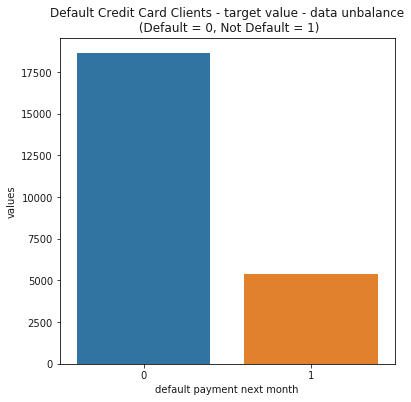

In [7]:
temp = data["default payment next month"].value_counts()
df = pd.DataFrame({'default payment next month': temp.index,'values': temp.values})
plt.figure(figsize = (6,6))
plt.title('Default Credit Card Clients - target value - data unbalance\n (Default = 0, Not Default = 1)')
sns.set_color_codes("pastel")
sns.barplot(x = 'default payment next month', y="values", data=df)
locs, labels = plt.xticks()
plt.show()

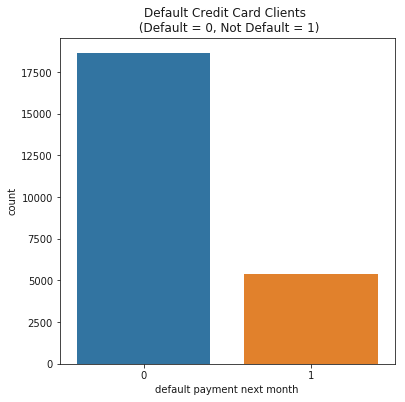

In [8]:
plt.figure(figsize = (6,6))
plt.title('Default Credit Card Clients \n (Default = 0, Not Default = 1)')
ax = sns.countplot(x="default payment next month", data=data)

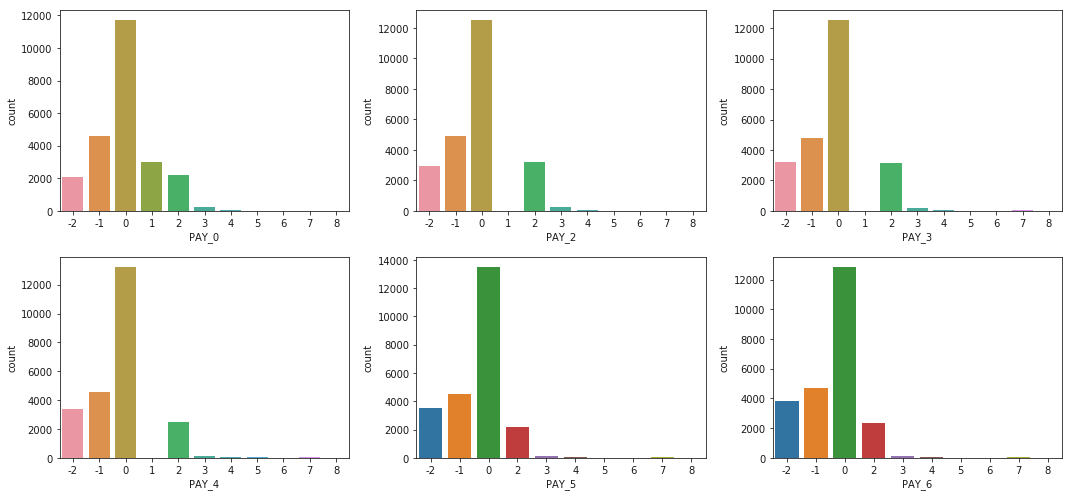

In [9]:
plt.figure(figsize = (15,10))
i = 0
for c in cols[3:]:
    i= i+1
    plt.subplot(3,3,i)
    ax = sns.countplot(x=c, data=data)
    plt.tight_layout() 

From the countplots we can observe that there are two unknown variable for repayment status:-2 and 0. Technically we should consider these variables as "NA" (Not Applicable). There are several methods to deal with this situation:

1.Remove observations
We can delete this data and ignore them but considering the vast amount of these observations, the loss of data would be too great.
2.Replace NAs with others

For now I think the best idea is to keep those observations as "NAs" and see how does it affect the predicted output.


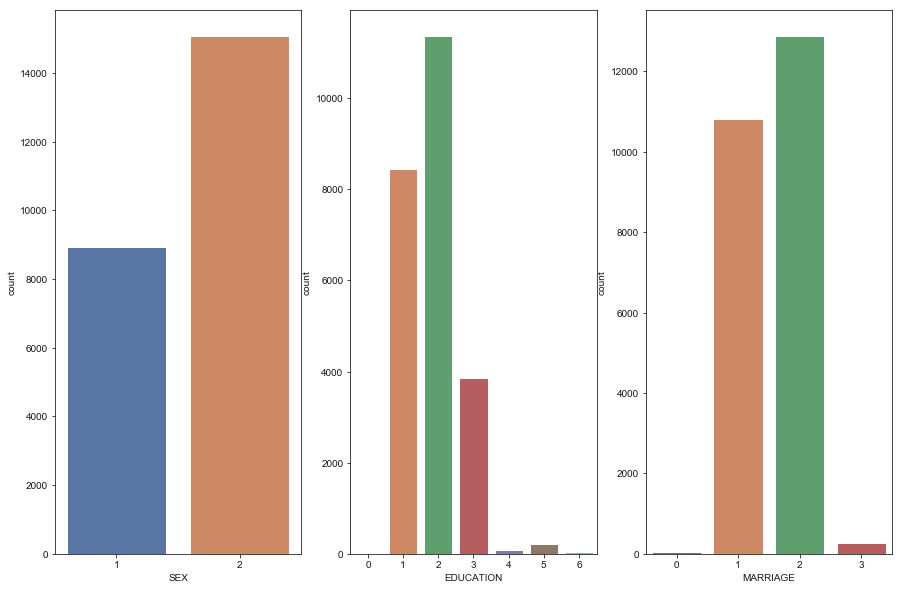

In [10]:
#Social Status(SEX, EDUCATION, MARRIAGE)

figs, axs = plt.subplots(1, 3, figsize=(15, 10))
axs = axs.ravel()

for counter in range(3):
    col = data.columns[2+counter]
    sns.set(style="darkgrid")
    sns.countplot(x=str(col), data=data,ax=axs[counter])
plt.show()


We summerise the sex, marriage and eduation as the social status factor. Again we notice that there are obervations with several undocumented values. For example, 0,5 and 6 for education. As I stated before, we could classify those as NA and  keep them as it is for now.

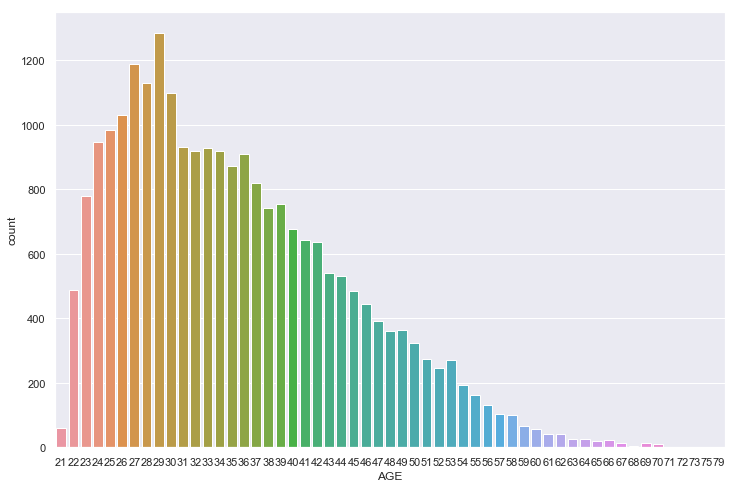

In [11]:
#Age counte
plt.figure(figsize=(12,8))
col = data.columns[5]
sns.set(style="darkgrid")
ax=sns.countplot(x=str(col), data=data)
plt.show()

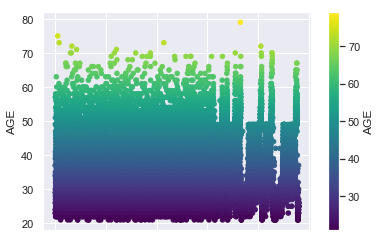

In [12]:
# #Age Scatter
ax2 = data.plot.scatter(x='ID', y='AGE',c='AGE', cmap='viridis')
plt.show()

Looking at the scatterplot, the strange thing is that with index more than 15000, the structure of the data seems like to have some kind of periodic patterns therefore we have drawed another histograms to analyse the strcture of the data.

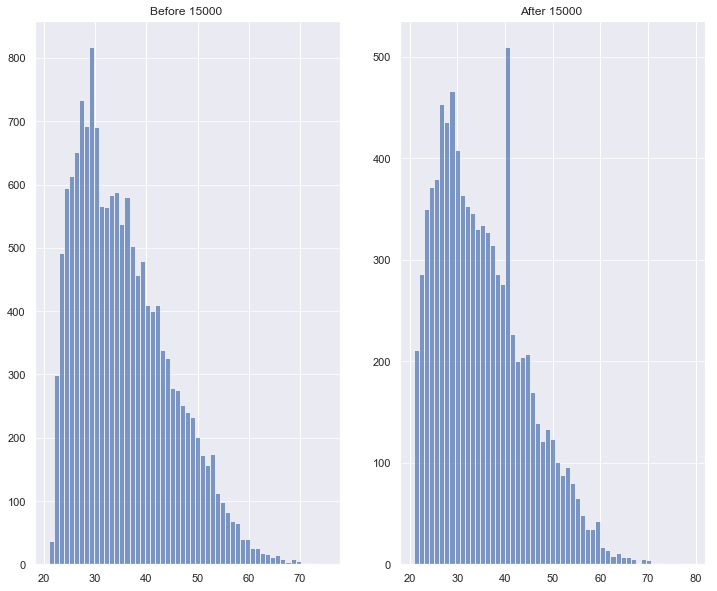

In [13]:
#comparing 2 groups
figs, axs = plt.subplots(1, 2, figsize=(12, 10))
#before 15000
col = data.columns[5]
distinct=len(data[col].unique())
axs[0].hist(data[col][:15000], bins=distinct,alpha=0.7)
axs[0].grid(axis='y',alpha=0.75)
axs[0].set_title("Before 15000 ")

#after 15000
col = data.columns[5]
distinct=len(data[col].unique())
axs[1].hist(data[col][15000:], bins=distinct,alpha=0.7)
axs[1].grid(axis='y',alpha=0.75)
axs[1].set_title("After 15000 ")

plt.show()

Text(0.5,1,'Before 15000 ')

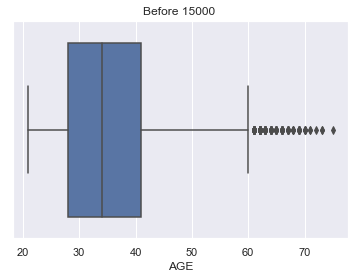

In [15]:
sns.boxplot(x=data[col][:15000]).set_title("Before 15000 ")


Text(0.5,1,'After 15000 ')

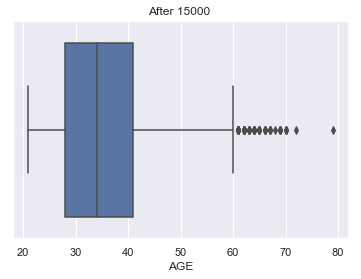

In [16]:
sns.boxplot(x=data[col][15000:]).set_title("After 15000 ")

 Both parts of the data hava the same structure and density, therefore the second part of the data is valid 

In [ ]:
figs, axs = plt.subplots(3, 2, figsize=(12, 10))
axs = axs.ravel()

for counter in range(6):
    col = data.columns[11 + counter]
    distinct=len(data[col].unique())
    sns.set(style="darkgrid")
    sns.countplot(x=str(col), data=data, ax=axs[counter])
plt.show()

Methodology Overview

Model training/validation

Results

Final predictions on test set